In [51]:
!pip install hmmlearn
!pip install yfinance

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm
import yfinance as yf

In [53]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 75;
num_models = 8;

In [54]:
df = yf.download("^NSEI",start='2015-01-01')
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [55]:
# Volatility is computed by obtaining variance between current close and prices of past 10 days
Volatility = []

# MA is the 10 day SMA
MA = []

# Return is the single-day percentage return
Return = []
ma_sum = 0;

# Warming up data for moving average and volatility calculations
for i in range (0, 10):
    Volatility.append(0);
    MA.append(0);
    Return.append(0);
    ma_sum += df['Close'][i];

# Filling in data for return, moving average, and volatility
for ind in df.index: 
    if ind >= 10:
        tail_close = df['Close'][ind-10];
        prev_close = df['Close'][ind-1];
        head_close = df['Close'][ind];
        ma_sum = (ma_sum - tail_close + head_close);
        ma_curr = ma_sum/10;
        MA.append(ma_curr);
        Return.append(((head_close-prev_close)/prev_close)*100);
        #Computing Volatility
        vol_sum = 0;
        for i in range (0,10):
            curr_vol = abs(ma_curr - df['Close'][ind-i]);
            vol_sum += (curr_vol ** 2);
        Volatility.append(vol_sum/10);

        

In [56]:
# Adding columns to dataframe
df['Volatility'] = Volatility;
df['MA'] = MA;
df['Return'] = Return;

In [57]:
# Dataframe readjustment
total_length = len(df)
drop_length = 0
training_length = len(df)
#test_length = total_length - drop_length - training_length
data_length = training_length
df = df.drop(range(0, drop_length));
df.index = range(0, data_length);

In [58]:
# Creating testing and training dataset
# 2000 datapoints in training, 838 datapoints in test

training = df.drop(range(training_length, data_length))

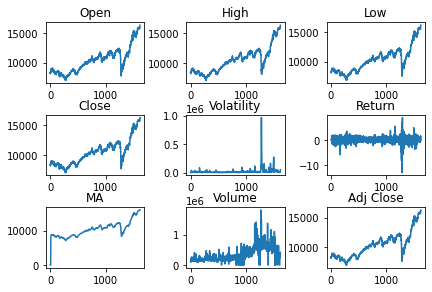

In [59]:
fig, a =  plt.subplots(3,3)
x = np.arange(1,5)
fig.tight_layout()
a[0][0].plot(range(0,training_length), training.iloc[:,1])
a[0][0].set_title('Open')
a[0][1].plot(range(0,training_length), training.iloc[:,2])
a[0][1].set_title('High')
a[0][2].plot(range(0,training_length), training.iloc[:,3])
a[0][2].set_title('Low')
a[1][0].plot(range(0,training_length), training.iloc[:,4])
a[1][0].set_title('Close')
a[1][1].plot(range(0,training_length), training.iloc[:,7])
a[1][1].set_title('Volatility')
a[1][2].plot(range(0,training_length), training.iloc[:,9])
a[1][2].set_title('Return')
a[2][0].plot(range(0,training_length), training.iloc[:,8])
a[2][0].set_title('MA')
a[2][1].plot(range(0,training_length), training.iloc[:,6])
a[2][1].set_title('Volume')
a[2][2].plot(range(0,training_length), training.iloc[:,5])
a[2][2].set_title('Adj Close')
plt.show()


In [60]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Volatility,MA,Return
0,2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900,0.0,0.0,0.0
1,2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,8378.400391,118200,0.0,0.0,0.0
2,2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,8127.350098,172800,0.0,0.0,0.0
3,2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098,8102.100098,164100,0.0,0.0,0.0
4,2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609,8234.599609,143800,0.0,0.0,0.0


In [61]:
# Creating the Hidden Markov Model
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations);
vol = training.iloc[:,7];
ret = training.iloc[:,9];
obs = [];
for i in range(0, len(vol)):
    arr = [];
    arr.append(vol[i]);
    arr.append(ret[i]);
    obs.append(arr);

# Fitting the model and obtaining predictions
model.fit(obs)
predictions = model.predict(obs)

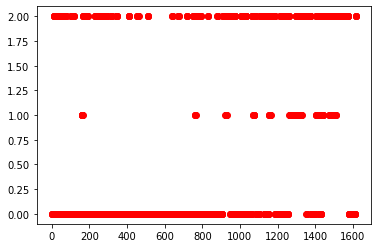

In [62]:
plt.plot(predictions, 'ro');

In [63]:
# Regime Classification
regime_vol = [];
regime_ret = [];
regime_count = [];
return_map = {};

for i in range(0, hidden_states):
    regime_vol.append(0);
    regime_ret.append(0);
    regime_count.append(0);

for i in range(0, len(predictions)):
    regime_count[predictions[i]] += 1;
    regime_vol[predictions[i]] += training.iloc[i, 7];
    regime_ret[predictions[i]] += training.iloc[i, 9];
    
    if not predictions[i] in return_map:
        return_map[predictions[i]] = [];
    return_map[predictions[i]].append(training.iloc[i,9]);
    
for i in range(0, hidden_states):
    regime_vol[i] = regime_vol[i] / regime_count[i];
    regime_ret[i] = regime_ret[i] / regime_count[i];

In [64]:
max_occurrence = np.argmax(regime_count)
for i in range(0, hidden_states):
    print("Regime {0}".format(i))
    print("Avg Vol: {0}".format(regime_vol[i]));
    print("Avg Return: {0}".format(regime_ret[i]));
    print("Occurrence: {0}\n".format(regime_count[i]));

Regime 0
Avg Vol: 5901.13360998504
Avg Return: 0.06560620761251448
Occurrence: 968

Regime 1
Avg Vol: 151450.4731435734
Avg Return: 0.004466413682337513
Occurrence: 112

Regime 2
Avg Vol: 23181.231370495636
Avg Return: 0.02048145651003566
Occurrence: 539



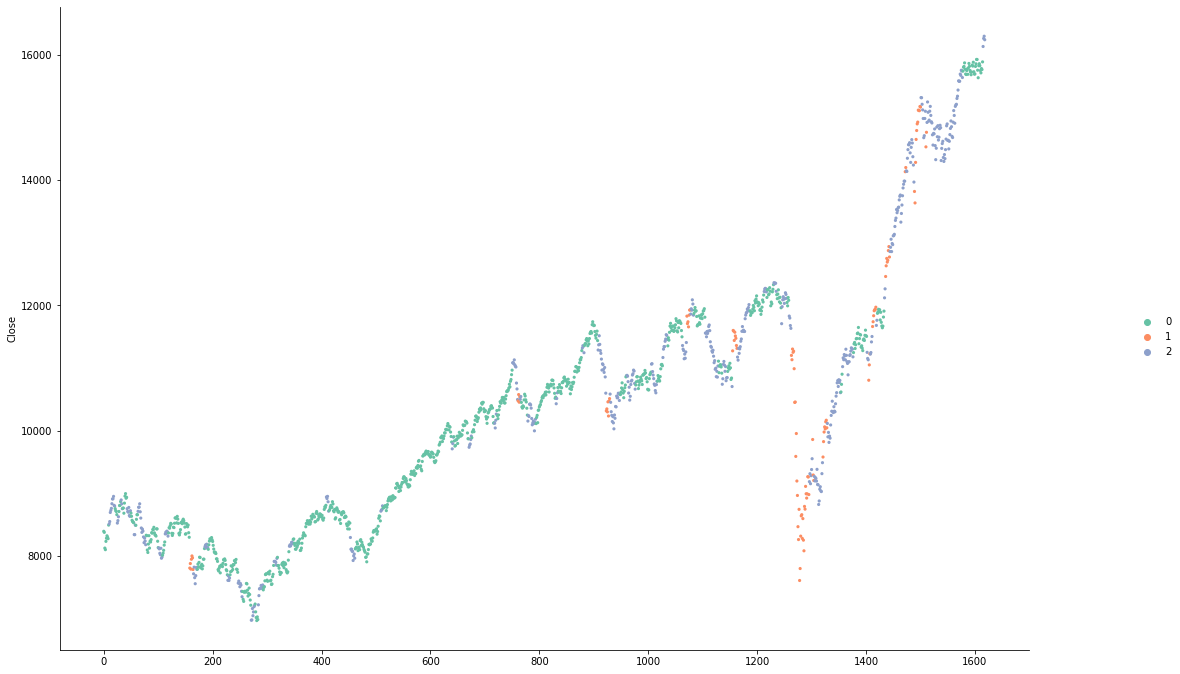

In [65]:
plot = sns.relplot(x=range(0,training_length), y="Close", data=training, hue=predictions, 
            linewidth = 0, palette="Set2", s = 10);
plot.fig.set_size_inches(18,10)

In [67]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: -18913.078051306115


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[Text(0, 0, '0'), Text(0, 0, '2'), Text(0, 0, '1')]

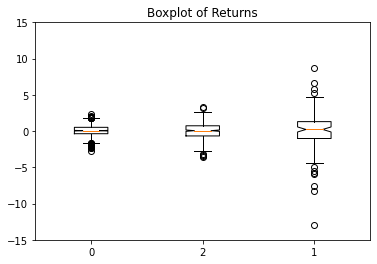

In [68]:
# Boxplot of returns
fig, ax = plt.subplots()
ax.set(ylim=(-15, 15))
ax.set_title("Boxplot of Returns")
ax.boxplot(return_map.values(), notch=True, vert = True, autorange = True)
ax.set_xticklabels(return_map.keys())